Importing libraries

In [2]:
import pybammeis
import pybamm
import os
import re
import numpy as np
from gamry_parser import GamryParser, Impedance
import pandas as pd
import time as timer
import matplotlib.pyplot as plt
from scipy.fft import fft
import random
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from scipy.interpolate import interp1d
import pyswarms as ps 
from pyswarms.single import GlobalBestPSO

Uploading experimental data

In [101]:
# ved ca. 45% SoC 
# ved 25 deg C

def get_exp_data(i, d): 
    z_list = []
    file = "/Users/synnemard/Desktop/lithium_ion/EIS data/MJ1_01_EIS-SoC_01-05/MJ1_01_EIS-SoC_0"+str(i)+"/"+d+"EISGALV3V587.DTA"
    ca = Impedance(file)
    ca.load(filename=file)

    # extract EIS curve
    res = ca.get_curve_data().iloc[::-1]
    df_real = res['Zreal']
    df_imag= res['Zimag']
    df_freq = res['Freq']
    df_name = res['Vdc']

    # Removing the points beneath the y-axis 
    real = df_real[df_imag <= 0]
    imag = df_imag[df_imag <= 0]
    freq = df_freq[df_imag <= 0]
    
    name = sum(df_name)/len(df_name)
    # Adding the impendances to the list 
    z_list.append(real)
    z_list.append(imag)
    return[z_list, freq, df_name]

get_exp_data(1, "d")[0]

get_exp_data(1, "d")[2]




KeyError: 'Vdc'

Plotting

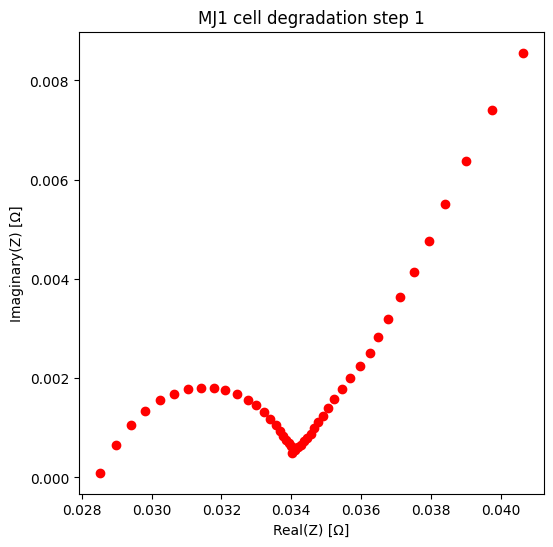

In [66]:
def plotting(i, d): 
    # Creating Nyquist plot
    plt.figure(figsize=(6,6))
    plt.scatter(get_exp_data(i, d)[0][0], -get_exp_data(i, d)[0][1], color='red') 

    # Labeling the plot
    plt.xlabel('Real(Z) [Ω]')
    plt.ylabel('Imaginary(Z) [Ω]')
    plt.title('MJ1 cell degradation step '+str(i))
    plt.show()

plotting(1, "")

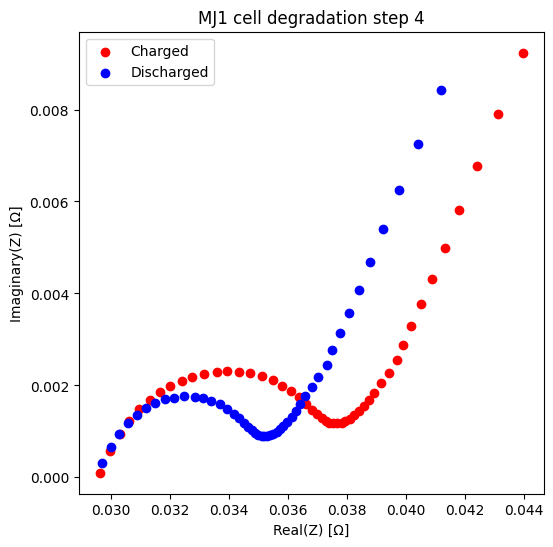

In [67]:
def combined_plot(i):
    # Creating the figure for both the charged and discharged data
    plt.figure(figsize=(6, 6))

    z_list_charged = get_exp_data(i, "")[0]
    z_list_discharged = get_exp_data(i, "d")[0]

    # Plot 
    plt.scatter(z_list_charged[0], -z_list_charged[1], color='red', label='Charged')
    plt.scatter(z_list_discharged[0], -z_list_discharged[1], color='blue', label='Discharged')

    # Adding labels and title
    plt.xlabel('Real(Z) [Ω]')
    plt.ylabel('Imaginary(Z) [Ω]')
    plt.title(f'MJ1 cell degradation step {i}')
    plt.legend()
    plt.show()

combined_plot(4)


Optimization of ECM parameters

In [88]:
# Randles components parameters 
c_elem = {
    "R_el": 0.026455095283510706,  # Electrolyte resistance (Ohms)
    "L": 5.534820787666664e-07, # Inductance (H)
    
    #Cathode? 
    "R_ct1": 0.0055426231465975665,  # Charge transfer resistance (Ohms)
    "Q1" : 0.6755099612832921, 
    "alpha1": 0.6624587164477784, 
    "A1": 0.0010503007445281985,     # Warburg coefficient
    "a_w1": 0.5722885441839765, 

    #Anode? 
    "R_ct2": 0.005384825939881047,  # Charge transfer resistance (Ohms)
    "Q2" : 2.339974970415867, 
    "alpha2": 0.8629910852751331, 
    "A2": 0.0011934570596558787,     # Warburg coefficient
    "a_w2": 0.5860161540205311, 
    }


# Function to convert dictionary to list
def dict_to_list(c_elem):
    return list(c_elem.values())

# Function to convert list back to dictionary
def list_to_dict(c_elem, optimized_values):
    keys = list(c_elem.keys())
    return dict(zip(keys, optimized_values))


In [89]:
exp_real = np.array(get_exp_data(4, "")[0][0])
exp_imag = np.array(get_exp_data(4, "")[0][1])
frequencies = np.array(get_exp_data(4, "")[1])


# Angular frequencies
ang_freq = 2*np.pi*frequencies

# Define Warburg impedance
def wni_imp(omega, A, a_w): # Non-Ideal 
    return A /(1j * omega)** a_w

# CPE for non-ideal capicitance behaviour
def cpe_imp(omega, Q, alpha): 
    return 1/(Q*(1j*omega)**alpha)

# Define Inductance impedance
def i_imp(omega, L): 
    return 1j*omega*L

# function for difference between the ECM model and the experimental values
def diff_func(comp, exp_real, exp_imag): 

    # Update c_elem dictionary from the flat parameter list (comp)
    c_elem_up = list_to_dict(c_elem, comp)

    Z_W1 = wni_imp(ang_freq, c_elem_up["A1"], c_elem_up["a_w1"])
    Z_cdl1 = cpe_imp(ang_freq, c_elem_up["Q1"], c_elem_up["alpha1"])
    Z_L = i_imp(ang_freq, c_elem_up["L"])

    Z_W2 = wni_imp(ang_freq, c_elem_up["A2"], c_elem_up["a_w2"])
    Z_cdl2 = cpe_imp(ang_freq, c_elem_up["Q2"], c_elem_up["alpha2"])

    Z1 =  1/(1/(c_elem_up["R_ct1"] + Z_W1) + 1/Z_cdl1)
    Z2 =  1/(1/(c_elem_up["R_ct2"] + Z_W2) + 1/Z_cdl2)
    Z = Z_L + c_elem_up["R_el"] + Z1 + Z2

    diff_real = Z.real - exp_real 
    diff_imag = Z.imag - exp_imag 
    sum_square_diff = np.sum(diff_real**2 + diff_imag**2)
    return sum_square_diff

# Convert initial dictionary to list for optimization
initial_elems = dict_to_list(c_elem)

options = {
    'maxiter': 10000,    # Maximum number of iterations
    'ftol': 1e-10,       # Function value tolerance
    #'disp': True         # Display convergence messages
}

# Minimize the difference function (optimize parameters)
opt = minimize(diff_func, initial_elems, args=(exp_real, exp_imag), method='TNC', options=options)

# Convert the optimized list back to dictionary
opt_elems = list_to_dict(c_elem, opt.x)

# Print the optimized elements
print("Optimized elements:", opt_elems)

# Print the difference after optimization
print("Final sum of squared difference:", diff_func(opt.x, exp_real, exp_imag))


/var/folders/18/pf3m4tds5qs9rpymkqv73yxc0000gn/T/ipykernel_22675/1977007380.py:53: OptimizeWarning: Unknown solver options: maxiter
  opt = minimize(diff_func, initial_elems, args=(exp_real, exp_imag), method='TNC', options=options)


Optimized elements: {'R_el': 0.02642787383303757, 'L': 5.610894993951355e-07, 'R_ct1': 0.005441107081214433, 'Q1': 0.6655780434184537, 'alpha1': 0.6644730115407022, 'A1': 0.0008327795602938238, 'a_w1': 0.5691817961982587, 'R_ct2': 0.005544924969105231, 'Q2': 2.5320295854529773, 'alpha2': 0.8382364485623848, 'A2': 0.0014073617702164605, 'a_w2': 0.5848995633541776}
Final sum of squared difference: 2.321400790810347e-06


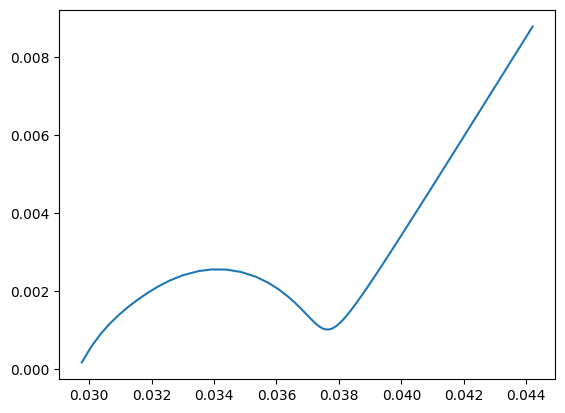

In [91]:
Z_W1 = wni_imp(ang_freq, opt_elems["A1"], opt_elems["a_w1"])
Z_cdl1 = cpe_imp(ang_freq, opt_elems["Q1"], opt_elems["alpha1"])
Z_L = i_imp(ang_freq, opt_elems["L"])

Z_W2 = wni_imp(ang_freq, opt_elems["A2"], opt_elems["a_w2"])
Z_cdl2 = cpe_imp(ang_freq, opt_elems["Q2"], opt_elems["alpha2"])

# Impedance from the Randles circuit 
def Z_randles(): 
    Z1 =  1/(1/(opt_elems["R_ct1"] + Z_W1) + 1/Z_cdl1)
    Z2 =  1/(1/(opt_elems["R_ct2"] + Z_W2) + 1/Z_cdl2)
    Z = Z_L + opt_elems["R_el"] + Z1 + Z2
    return Z  

plt.plot(Z_randles().real, -Z_randles().imag)
plt.show()

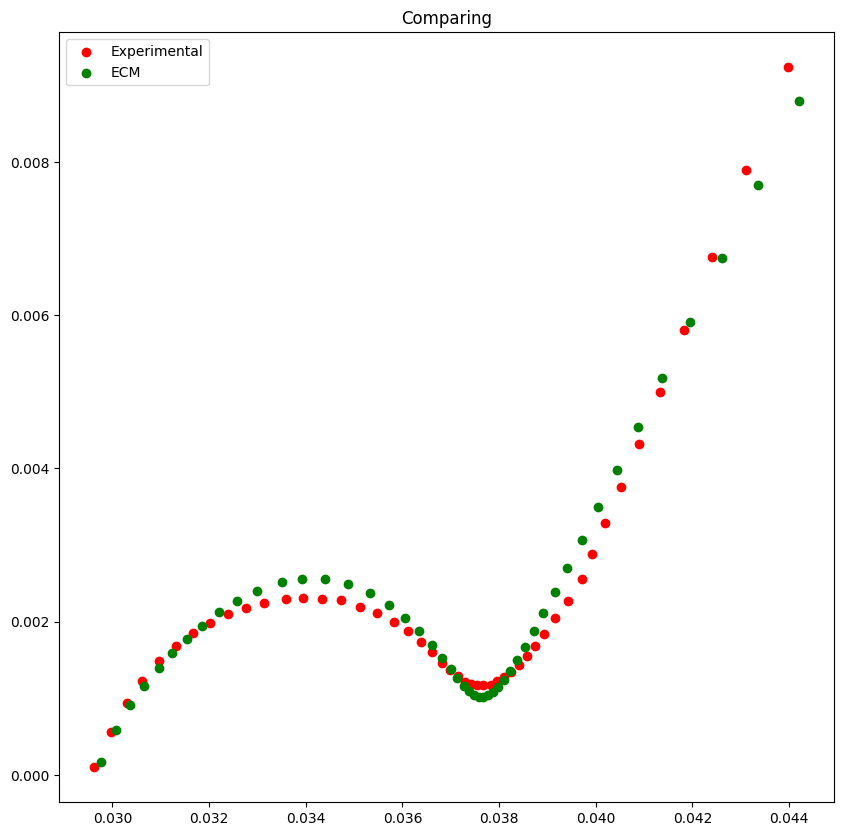

In [93]:
fig, ax = plt.subplots(figsize=(10, 10)) 
ax.scatter(exp_real, -exp_imag, label=f"Experimental", color = 'red') 
ax.scatter(Z_randles().real, -Z_randles().imag, label = f'ECM', color = 'green')

#ax.set_xlim(0.016, 0.045) 
#ax.set_ylim(0, 0.012)

plt.legend()
plt.title("Comparing") 
plt.show() 